# CS109b - Final Project - Milestone 5

# Multilabel classification using ResNet50 as feature extractor

## Angappan, Bend, Smadja

In [1]:
!pip3 install Pillow

  Using cached Pillow-4.1.1-cp35-cp35m-manylinux1_x86_64.whl
You are using pip version 8.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip3 install h5py

  Using cached h5py-2.7.0-cp35-cp35m-manylinux1_x86_64.whl
  Using cached six-1.10.0-py2.py3-none-any.whl
  Using cached numpy-1.12.1-cp35-cp35m-manylinux1_x86_64.whl
You are using pip version 8.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from __future__ import print_function

from PIL import Image

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Input
from keras.optimizers import SGD
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, list_pictures

import h5py

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np
import os


Using TensorFlow backend.


# 1. Preparing the data

In Milestone4, we limited our data extraction to three genres: action, comedy and drama and considered only the first genre. Also, we restricted ourselves to 300 movies only. We realized that for deep learning to give better results and without overfitting, we need a bigger dataset. So we decided to use a dataset of 5000 movies across 10 years. Also, every movie can be classified into multiple genres i.e. a family movie could be classified into comedy genre as well. Hence, for all the 5000 movies, we considered the top 5 genres as well for classification purposes.

We used TMDB APIs(discover) to download movie details and posters of 5000 movies. This data was uploaded to a p2.xlarge instance of AWS and we continued to use the instance for our analysis purposes.

In [4]:
movies_df = pd.read_csv('/home/ubuntu/FinalMilestoneMovies10yrs.csv')
movies_df = movies_df.drop(["Unnamed: 6", "Unnamed: 7", "Unnamed: 8", "Unnamed: 9", "Unnamed: 10", "Unnamed: 11"],1)
movies_df = movies_df.astype(int)
movies_df.head(1)

,ids,genre1,genre2,genre3,genre4,genre5
0,335797,16,35,18,10751,10402


In [5]:
movies_df70 = pd.read_csv('/home/ubuntu/FinalMilestoneMovies70.csv')
movies_df70 = movies_df70.astype(int)
movies_df70.head(1)

,ids,genre1,genre2,genre3,genre4,genre5
0,28,18,10752,0,0,0


Overall, movies can be classified into 19 genres. For every movie, we consider the first five genres for classification purposes.

In [6]:
all_genres = [12, 14, 16, 18, 27, 28, 35, 36, 37, 53, 80, 99, 878, 9648, 10402, 10749, 10751, 10752, 10770]
all_genres = np.array(all_genres)
all_genres = all_genres.astype(int)

TMDB API provides the movie genres as an array. We cannot use the array as such for the machine learning algorithms. Though the genres are numerical in nature, they are categorical variables. So, it is required to perform one-hot encoding of these variables. keras.utils.to_categorical can be used for one-hot encoding but unfortunately, this works only for multi-class scenario. So, we manually did a one-hot encoding and converted the genres as binary variables.

In [7]:
genre_df = pd.DataFrame(index = range(len(movies_df)), columns = all_genres)
genre_df['movie-id'] = ''

for index, row in movies_df.iterrows():
    genres = np.zeros(len(genre_df.columns))
    g1 = row['genre1']
    if(g1 in all_genres):
        genre_index = genre_df.columns.get_loc(g1)
        genres[genre_index] = 1
    g2 = row['genre2']
    if(g2 in all_genres):
        genre_index = genre_df.columns.get_loc(g2)
        genres[genre_index] = 1
    g3 = row['genre3']
    if(g3 in all_genres):
        genre_index = genre_df.columns.get_loc(g3)
        genres[genre_index] = 1
    g4 = row['genre4']
    if(g4 in all_genres):
        genre_index = genre_df.columns.get_loc(g4)
        genres[genre_index] = 1
    g5 = row['genre5']
    if(g5 in all_genres):
        genre_index = genre_df.columns.get_loc(g5)
        genres[genre_index] = 1
    genres = genres.astype(int)
    genres[-1] = row['ids']
    genre_df.loc[index] = genres

In [8]:
genre_df70 = pd.DataFrame(index = range(len(movies_df70)), columns = all_genres)
genre_df70['movie-id'] = ''

for index, row in movies_df70.iterrows():
    genres = np.zeros(len(genre_df70.columns))
    g1 = row['genre1']
    if(g1 in all_genres):
        genre_index = genre_df70.columns.get_loc(g1)
        genres[genre_index] = 1
    g2 = row['genre2']
    if(g2 in all_genres):
        genre_index = genre_df70.columns.get_loc(g2)
        genres[genre_index] = 1
    g3 = row['genre3']
    if(g3 in all_genres):
        genre_index = genre_df70.columns.get_loc(g3)
        genres[genre_index] = 1
    g4 = row['genre4']
    if(g4 in all_genres):
        genre_index = genre_df70.columns.get_loc(g4)
        genres[genre_index] = 1
    g5 = row['genre5']
    if(g5 in all_genres):
        genre_index = genre_df70.columns.get_loc(g5)
        genres[genre_index] = 1
    genres = genres.astype(int)
    genres[-1] = row['ids']
    genre_df70.loc[index] = genres

In [9]:
genre_df.index = genre_df["movie-id"]
genre_df = genre_df.drop("movie-id",1)

path = '/home/ubuntu/Posters2010/'
posters = list_pictures(path)

In [10]:
genre_df70.index = genre_df70["movie-id"]
genre_df70 = genre_df70.drop("movie-id",1)

path70 = '/home/ubuntu/Posters1970/'
posters70 = list_pictures(path70)
posters70[:3]

['/home/ubuntu/Posters1970/4279.jpg',
 '/home/ubuntu/Posters1970/7070.jpg',
 '/home/ubuntu/Posters1970/11072.jpg']

# 2. Deep Learning Strategies

In the previous milestones, we used traditional approaches like PCA to reduce the dimensions and fit a KNN / SVM / Random Forests model on the pictures. We realized that though 2 dimensional PCA was able to explain 65% variance in posters, this was still not enough to classify genres correctly based on these traditional methods. Hence we switch to Deep learning methods like CNN / MLP to classify the posters by genre(s). Below, we try different strategies and discuss the output of each strategy.


# 2.1 Strategy 1: 49 shades of ResNet50 + SVM

We use below the pretrained ResNet50 model combined with an SVM to classify our images. We found ResNet50 having many more layers and also seem to be much more matured.

We don't actually use the full model. The first convolution layers are preparing the features that the last fully connected layer uses to classify images. We use an SVM to do the actual genre classification using the features extracted by the first layers.

For the ResNet50 model, we exclude the last fully connected, incorporated the pre-trained 'imagenet' weights, altered the default shape to our smaller 320x200 and opted not to use any pooling.

In [12]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

# set up ResNet50 model, minus the top layer
model_resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(320,200,3))
model_resnet50.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 320, 200, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 326, 206, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 160, 100, 64)  9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 160, 100, 64)  256                                          
___________________________________________________________________________________________

In [13]:
# Look at the weights of the first convolution layer
layer = model_resnet50.layers[2]
# this actually returns a list 
# first element is W
# second element are all the biases b
weights = layer.get_weights()
# the weights are the number of pixels times the number of filters (hidden units)
print("Shape of W")
print(weights[0].shape)


Shape of W
(7, 7, 3, 64)


We can see below the Feature Visualization of the first 8 filters of the pre-trained network ResNet50.

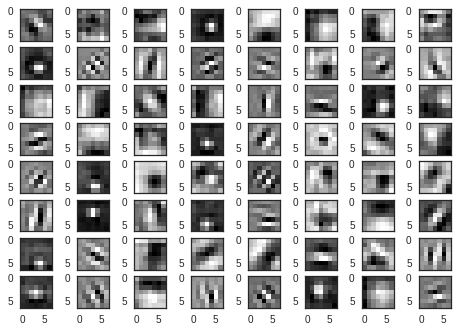

In [14]:
# make a figure for the first 8 filters
index = 0
for i in range(8):
    for j in range(8):
        w = weights[0][:,:,0,index]
        w = w.reshape(7,7)
        index+=1
        plt.subplot(8,8,index)
        plt.imshow(w, cmap='gray')    

plt.show()

In [31]:
# Look at the weights of the first convolution layer
for i in range(3,40):
    layer = model_resnet50.layers[i]
    # this actually returns a list 
    # first element is W
    # second element are all the biases b
    weights = layer.get_weights()
    # the weights are the number of pixels times the number of filters (hidden units)
    if(len(weights)>1):
        print(i, weights[0].shape)


3 (64,)
6 (1, 1, 64, 64)
7 (64,)
9 (3, 3, 64, 64)
10 (64,)
12 (1, 1, 64, 256)
13 (1, 1, 64, 256)
14 (256,)
15 (256,)
18 (1, 1, 256, 64)
19 (64,)
21 (3, 3, 64, 64)
22 (64,)
24 (1, 1, 64, 256)
25 (256,)
28 (1, 1, 256, 64)
29 (64,)
31 (3, 3, 64, 64)
32 (64,)
34 (1, 1, 64, 256)
35 (256,)
38 (1, 1, 256, 128)
39 (128,)


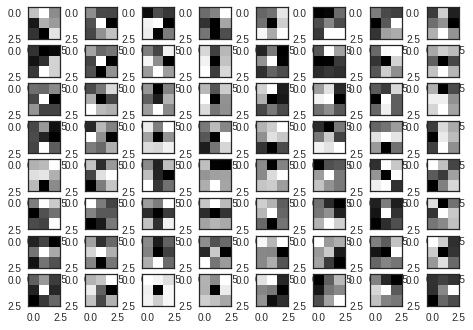

In [32]:
layer = model_resnet50.layers[21]
weights = layer.get_weights()
index = 0
for i in range(8):
    for j in range(8):
        w = weights[0][:,:,0,index]
        w = w.reshape(3,3)
        index+=1
        plt.subplot(8,8,index)
        plt.imshow(w, cmap='gray')    

plt.show()

We now transform the poster data to x and y, so it can be further split to train and test data sets.

In [33]:
x = []
y = []

# Convert grayscal images (w, h, 1) arrays into rgb images (w, h, 3) arrays
def to_rgb(im):
    w, h, one = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im[:, :, 0]
    ret[:, :, 1] = im[:, :, 0]
    ret[:, :, 2] = im[:, :, 0]
    return ret

for poster in posters:
    #img = load_img(poster, target_size =(750, 500)) # "requires PIL" whereas PIL is running... don't understand why
    img = Image.open(poster)
    img = img.resize((200,320))
    img_array = img_to_array(img)
    if (img_array.shape == (320, 200, 1)):
        img_array = to_rgb(img_array)
    if (img_array.shape != (320, 200, 3)):
        print(poster, img_array.shape)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32')
    img_array = preprocess_input(img_array)
    pred = model_resnet50.predict(img_array) ## use ResNet model to predict
    x.append(pred[0,0,0,:])
    imdb_id = int(poster[25:-4])
    y.append(genre_df.loc[imdb_id].values)
    
x = np.asarray(x)
y = np.asarray(y)
print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: (5000, 2048)
y shape: (5000, 19)


In [34]:
x_tv, x_test, y_tv, y_test = train_test_split(x, y, test_size = 0.1)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2)
del x, y
print(x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(4000, 2048) (1000, 2048) (500, 2048) (4000, 19) (1000, 19) (500, 19)


In [36]:
x70 = []
y70 = []

for poster in posters70:
    img = Image.open(poster)
    img = img.resize((200,320))
    img_array = img_to_array(img)
    if (img_array.shape == (320, 200, 1)):
        img_array = to_rgb(img_array)
    if (img_array.shape != (320, 200, 3)):
        print(poster, img_array.shape)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32')
    img_array = preprocess_input(img_array)
    pred = model_resnet50.predict(img_array) ## use ResNet model to predict
    x70.append(pred[0,0,0,:])
    imdb_id = int(poster[25:-4])
    y70.append(genre_df70.loc[imdb_id].values)
    
x70 = np.asarray(x70)
y70 = np.asarray(y70)
print("x shape:", x70.shape)
print("y shape:", y70.shape)

x shape: (4809, 2048)
y shape: (4809, 19)


In [37]:
x70_tv, x70_test, y70_tv, y70_test = train_test_split(x70, y70, test_size = 0.1)
x70_train, x70_valid, y70_train, y70_valid = train_test_split(x70, y70, test_size = 0.2)
del x70, y70
print(x70_train.shape, x70_valid.shape, x70_test.shape, y70_train.shape, y70_valid.shape, y70_test.shape)

(3847, 2048) (962, 2048) (481, 2048) (3847, 19) (962, 19) (481, 19)


### Fit an RBF-SVM using ResNet features as input

Since we have only 5000 images to work with and we are only using 2048 features outputted by the 49th layer of ResNet, SVM with RBF kernel could be more efficient. 
We fit the SVM on the images from the 2010's and we test our predictions on the testing sets of both the 2010's and 1970's. 

In [38]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

clf = OneVsRestClassifier(SVC(C=1, kernel='rbf'))
clf.fit(x_train, y_train)  

In [48]:
y_pred = clf.predict(x_test)
y70_pred = clf.predict(x70_test)

### Precision / Recall

Our problem includes a lot of ‘negatives’ (a movie does not belong to a genre). A naïve model that forecasts that movies do not belong to any genre would do pretty well if we were to compute a simple accuracy ratio. Hence we use the F1 score to compare the different models. This measure is the harmonic mean of precision (number of correct positive results divided by the number of all positive results) and recall (number of correct positive results divided by the number of positive results that should have been returned). The score reaches its best value at 1 and worst at 0.

In [51]:
import warnings
warnings.filterwarnings("ignore")

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        84
          1       0.00      0.00      0.00        44
          2       0.97      0.71      0.82        41
          3       0.80      0.81      0.81       257
          4       0.00      0.00      0.00        28
          5       0.89      0.79      0.83       210
          6       0.84      0.79      0.81       194
          7       0.00      0.00      0.00        12
          8       0.00      0.00      0.00         9
          9       0.92      0.30      0.45       121
         10       0.00      0.00      0.00        61
         11       0.00      0.00      0.00         4
         12       1.00      0.07      0.13        58
         13       0.00      0.00      0.00        20
         14       0.00      0.00      0.00        15
         15       0.00      0.00      0.00        86
         16       1.00      0.58      0.74        24
         17       0.00      0.00      0.00   

In [52]:
print(classification_report(y70_test, y70_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        52
          1       0.00      0.00      0.00        10
          2       0.16      0.50      0.24         6
          3       0.66      0.51      0.58       232
          4       0.00      0.00      0.00        18
          5       0.62      0.51      0.56       175
          6       0.55      0.73      0.63       193
          7       0.00      0.00      0.00        19
          8       0.00      0.00      0.00        22
          9       0.17      0.02      0.04        48
         10       0.00      0.00      0.00        68
         11       0.00      0.00      0.00         1
         12       0.00      0.00      0.00         9
         13       0.00      0.00      0.00        18
         14       0.00      0.00      0.00        12
         15       0.00      0.00      0.00        42
         16       0.00      0.00      0.00        24
         17       0.00      0.00      0.00   

We got an F1-Score of 0.51 for the 10 years of movies and 0.37 for the 1970's movies. This shows us that there is some more work to do to improve the accuracy. Also, we try to see whether a decade specific model (1970s) will be able to classify the movies in general.

In [41]:
clf70 = OneVsRestClassifier(SVC(C=1, kernel='rbf'))
clf70.fit(x70_train, y70_train)  

In [53]:
y_pred = clf70.predict(x_test)
y70_pred = clf70.predict(x70_test)

In [54]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        84
          1       0.00      0.00      0.00        44
          2       0.00      0.00      0.00        41
          3       0.64      0.77      0.70       257
          4       0.00      0.00      0.00        28
          5       0.81      0.51      0.63       210
          6       0.77      0.39      0.51       194
          7       0.00      0.00      0.00        12
          8       0.00      0.00      0.00         9
          9       0.00      0.00      0.00       121
         10       0.00      0.00      0.00        61
         11       0.00      0.00      0.00         4
         12       0.00      0.00      0.00        58
         13       0.00      0.00      0.00        20
         14       0.00      0.00      0.00        15
         15       0.00      0.00      0.00        86
         16       0.00      0.00      0.00        24
         17       0.00      0.00      0.00   

In [55]:
print(classification_report(y70_test, y70_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        52
          1       0.00      0.00      0.00        10
          2       0.00      0.00      0.00         6
          3       0.77      0.68      0.72       232
          4       0.00      0.00      0.00        18
          5       0.80      0.63      0.71       175
          6       0.79      0.60      0.68       193
          7       0.00      0.00      0.00        19
          8       0.00      0.00      0.00        22
          9       0.00      0.00      0.00        48
         10       0.00      0.00      0.00        68
         11       0.00      0.00      0.00         1
         12       0.00      0.00      0.00         9
         13       0.00      0.00      0.00        18
         14       0.00      0.00      0.00        12
         15       0.00      0.00      0.00        42
         16       0.00      0.00      0.00        24
         17       0.00      0.00      0.00   

### Imbalanced Data

The F1-score did not improve beyond 0.44, and this is not a good classification accuracy. On close analysis, we can see that, one of the reasons could be the data is imbalanced. Not many movies have the same genre and the combination of genres could be different for each movie. This imbalance could cost the classification accuracy and thus the F1-score as well. Data Imbalance can be taken care by increasing the number of observations we work with. But this also requires higher GPU (as we are dealing with images here). There are limits for p2.xlarge instance that we use and we will try to improve the accuracy with the data that we have.

So, we create SVM with balanced class weights, so SVM takes care of this imbalance automatically.

In [84]:
# SVM on 2010's posters with 'balanced' classes
clf = OneVsRestClassifier(SVC(C=1, kernel='rbf', class_weight='balanced'))
clf.fit(x_train, y_train)  

OneVsRestClassifier(estimator=SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [85]:
y_pred = clf.predict(x_test)
y70_pred = clf.predict(x70_test)

In [86]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.51      0.87      0.65        84
          1       0.49      0.95      0.65        44
          2       0.81      0.95      0.88        41
          3       0.80      0.81      0.80       257
          4       0.37      0.96      0.53        28
          5       0.84      0.85      0.84       210
          6       0.80      0.88      0.84       194
          7       0.38      0.83      0.53        12
          8       1.00      0.78      0.88         9
          9       0.56      0.91      0.70       121
         10       0.39      0.90      0.55        61
         11       1.00      0.75      0.86         4
         12       0.51      0.88      0.65        58
         13       0.31      0.75      0.43        20
         14       0.70      0.93      0.80        15
         15       0.48      0.93      0.64        86
         16       0.44      1.00      0.62        24
         17       0.52      0.85      0.65   

In [87]:
print(classification_report(y70_test, y70_pred))

             precision    recall  f1-score   support

          0       0.23      0.56      0.33        52
          1       0.01      0.10      0.02        10
          2       0.06      0.83      0.11         6
          3       0.66      0.52      0.58       232
          4       0.06      0.11      0.08        18
          5       0.56      0.59      0.57       175
          6       0.50      0.79      0.61       193
          7       0.31      0.26      0.29        19
          8       0.67      0.09      0.16        22
          9       0.17      0.29      0.21        48
         10       0.30      0.29      0.30        68
         11       0.00      0.00      0.00         1
         12       0.12      0.67      0.21         9
         13       0.00      0.00      0.00        18
         14       0.08      0.08      0.08        12
         15       0.18      0.52      0.27        42
         16       0.12      0.33      0.18        24
         17       0.29      0.22      0.25   

And the "balanced" class-weights definitely had some impact. The F1-score jumped all the way from 0.44 to 0.74 which is very good improvement. This is definitely a better model after introducing the "balanced" weights.




## 2.2. Strategy 2: ResNet50 as initialization

In this strategy, we repeated the experiment with a neural network using the features extracted from ResNet50. We added 4 fully connected layers with 500, 250, 250 and 100 neurons respectively. We used a ReLU activation function for each. We used the basic ‘deep learning tricks’ to make sure we did not overfit or that the fitting was optimal. We used dropout filters set at 20%.

### Dropout 

Dropout can be applied to input neurons and between each hidden layers. We are using a pretrained model here so we will only use this option between the two fully connected layers that we add to the ResNet50's structure. 
 
Following the recommendations of the original paper on Dropout, we added a constraint on the weights for each hidden layer, ensuring that the maximum norm of the weights does not exceed a value of 3. 

### Learning Rate Schedule

There are two simple strategies to decrease progressively the learning rate. Either decreasing it gradually at each epoch or at a regular interval by a bigger percentage. We implement here the second approach. 


### Early stop

We use a patience of 10 epochs, if there is no improvement in the validation accuracy after 10 epochs, we stop the process.


In [80]:
from keras.layers import Input, Dropout
from keras.models import Model
from keras.constraints import maxnorm
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping  
import math

#Learning Schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drops = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drops))
    return lrate

model = Sequential()
model.add(Dense(500, input_shape=(2048,), activation= 'relu', kernel_constraint=maxnorm(3), name='fc1'))
model.add(Dropout(0.2))
model.add(Dense(250, input_shape=(2048,), activation= 'relu', kernel_constraint=maxnorm(3), name='fc2'))
model.add(Dropout(0.2))
model.add(Dense(250, activation= 'relu', kernel_constraint=maxnorm(3), name='fc3'))
model.add(Dropout(0.2))
model.add(Dense(100, activation= 'relu', kernel_constraint=maxnorm(3), name='fc4'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='sigmoid',init='uniform', name='prediction'))
    
model.summary()

#Compile the model
sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

#Callback
lrate = LearningRateScheduler(step_decay)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
callbacks_list = [lrate, early_stop]

#Training the model
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),  epochs=200, batch_size = 256, callbacks=callbacks_list, verbose=1)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 500)               1024500   
_________________________________________________________________
dropout_26 (Dropout)         (None, 500)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 250)               125250    
_________________________________________________________________
dropout_27 (Dropout)         (None, 250)               0         
_________________________________________________________________
fc3 (Dense)                  (None, 250)               62750     
_________________________________________________________________
dropout_28 (Dropout)         (None, 250)               0         
_________________________________________________________________
fc4 (Dense)                  (None, 100)               25100     
__________

In [ ]:
model.save('/home/ubuntu/ResNet_Init.h5') #creates a HDF5 file 

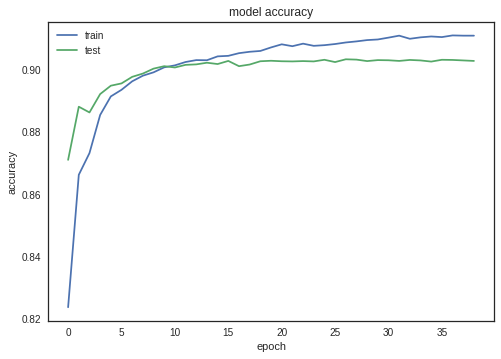

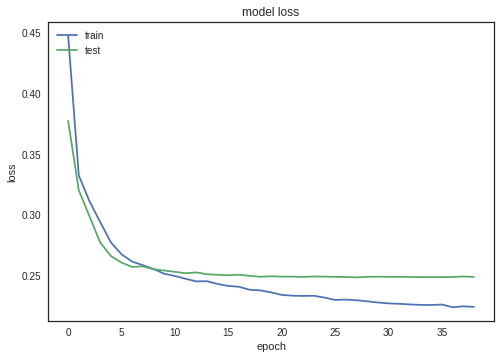

In [81]:
# list all data in history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [83]:
y_pred = model.predict(x_test)
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.53      0.24      0.33        84
          1       0.00      0.00      0.00        44
          2       0.82      0.68      0.75        41
          3       0.81      0.72      0.76       257
          4       0.00      0.00      0.00        28
          5       0.85      0.80      0.83       210
          6       0.82      0.82      0.82       194
          7       0.00      0.00      0.00        12
          8       0.00      0.00      0.00         9
          9       0.67      0.57      0.62       121
         10       0.69      0.18      0.29        61
         11       0.00      0.00      0.00         4
         12       0.45      0.17      0.25        58
         13       0.00      0.00      0.00        20
         14       0.00      0.00      0.00        15
         15       0.72      0.21      0.32        86
         16       0.88      0.62      0.73        24
         17       0.00      0.00      0.00   

In [78]:
y70_pred = model.predict(x70_test)
y70_pred[y70_pred>=0.5] = 1
y70_pred[y70_pred<0.5] = 0

print(classification_report(y70_test, y70_pred))

             precision    recall  f1-score   support

          0       0.38      0.12      0.18        52
          1       0.00      0.00      0.00        10
          2       0.10      0.50      0.17         6
          3       0.66      0.53      0.59       232
          4       0.00      0.00      0.00        18
          5       0.59      0.55      0.57       175
          6       0.55      0.72      0.62       193
          7       0.00      0.00      0.00        19
          8       0.00      0.00      0.00        22
          9       0.21      0.15      0.17        48
         10       0.60      0.04      0.08        68
         11       0.00      0.00      0.00         1
         12       0.25      0.33      0.29         9
         13       0.00      0.00      0.00        18
         14       0.00      0.00      0.00        12
         15       0.20      0.05      0.08        42
         16       0.00      0.00      0.00        24
         17       0.00      0.00      0.00   

The above gave better results, but not still better than the first strategy.


# 2.3. Strategy 3: CNN from Scratch using all layers

This is a much simpler model, without modifying the layers / adding any traditional algorithms in the classification process. We would like to see how a simple straight forward model would classify the genres.

And yes, this model also does a multilabel classification.

In this strategy, we create a model from scratch and we compute f1-score as we did earlier.
We use a different dataset (a smaller one i.e. 1000 movies released in years 2015 and 2016).

We uploaded onto an EC2 p2.xlarge instance 1010 posters using FileZilla. Almost all the images have a 500 * 350 resolution but some had a slightly different one. We used matplotlib's resize function to make sure the resolution was exactly the same for all images. We failed to use the load_img function from Keras. We kept getting an error message that the library PIL was missing despite successfull install and import. 

For the 1010 movies, there were 19 unique classes. We considered a maximum of genres per movie. We did one hot encoding of these classes against each movie. After the one-hot encoding our y became a matrix of (1010, 20).

### Loading the data

In [2]:
movies_df = pd.read_csv('FinalMilestoneMovies.csv')
movies_df.head()

,Unnamed: 0,genre1,genre2,genre3,genre4,genre5,ids,language,overview,popularity,poster_path,release_date,release_year,title,vote_average
0,0,16,35,18,10751,10402,335797,en,A koala named Buster recruits his best friend ...,56.917533,/eSVtBB2PVFbQiFWC7CQi3EjIZnn.jpg,2016-11-23,2016,Sing,6.8
1,1,28,18,878,0,0,330459,en,A rogue band of resistance fighters unite for ...,26.293151,/qjiskwlV1qQzRCjpV0cL9pEMF9a.jpg,2016-12-14,2016,Rogue One: A Star Wars Story,7.3
2,2,35,18,10402,10749,0,313369,en,"Mia, an aspiring actress, serves lattes to mov...",21.787982,/ylXCdC106IKiarftHkcacasaAcb.jpg,2016-11-29,2016,La La Land,7.9
3,3,53,18,878,9648,0,329865,en,Taking place after alien crafts land around th...,21.781708,/hLudzvGfpi6JlwUnsNhXwKKg4j.jpg,2016-11-10,2016,Arrival,6.9
4,4,18,35,0,0,0,382591,fr,A man without attachments or responsibilities ...,19.939147,/muwaDIv5cLv2Z07CZFWOsL7lYuO.jpg,2016-12-07,2016,Tomorrow Everything Starts,7.6


In [3]:
import numpy as np
all_genres = []
all_genres.append(movies_df['genre1'].values)
all_genres.append(movies_df['genre2'].values)
all_genres.append(movies_df['genre3'].values)
all_genres.append(movies_df['genre4'].values)
all_genres.append(movies_df['genre5'].values)
all_genres = np.array(all_genres)
all_genres = np.unique(all_genres[~np.isnan(all_genres)])
all_genres = all_genres.astype(int)
all_genres

array([    0,    12,    14,    16,    18,    27,    28,    35,    36,
          37,    53,    80,    99,   878,  9648, 10402, 10749, 10751,
       10752, 10770])

In [4]:
genre_df = pd.DataFrame(index = range(len(movies_df)), columns = all_genres)
genre_df['movie-id'] = ''

for index, row in movies_df.iterrows():
    genres = np.zeros(len(genre_df.columns))
    genre_index = genre_df.columns.get_loc(row['genre1'])
    genres[genre_index] = 1
    genre_index = genre_df.columns.get_loc(row['genre2'])
    genres[genre_index] = 1
    genre_index = genre_df.columns.get_loc(row['genre3'])
    genres[genre_index] = 1
    genre_index = genre_df.columns.get_loc(row['genre4'])
    genres[genre_index] = 1
    genre_index = genre_df.columns.get_loc(row['genre5'])
    genres[genre_index] = 1
    genres = genres.astype(int)
    genres[-1] = row['ids']
    genre_df.loc[index] = genres

#0 is not a valid genre. Had to add it to avoid NaNs. Now remove the classifier from the list.
genre_df = genre_df.drop(0, 1)
genre_df.head()

,12,14,16,18,27,28,35,36,37,53,80,99,878,9648,10402,10749,10751,10752,10770,movie-id
0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,335797
1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,330459
2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,313369
3,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,329865
4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,382591


In [5]:
x = []
y = []
import os
images = os.listdir("./FinalMilestonePosters_Resized")
for img_jpg in images:
    img = Image.open('./FinalMilestonePosters_Resized/' + str(img_jpg))
    img_array = img_to_array(img)
    x.append(img_array)
    movie_id = str(img_jpg).split('_')[0]
    genres = genre_df[(genre_df['movie-id'] == int(movie_id))].values    
    y.append(genres[0][:-1])
    
x = np.asarray(x)
y = np.asarray(y)
print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: (1010, 500, 350, 3)
y shape: (1010, 19)


In [6]:
# create training and testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(808, 500, 350, 3) (202, 500, 350, 3) (808, 19) (202, 19)


In [7]:
# input image dimensions
img_rows, img_cols = x_train.shape[1], x_train.shape[2]
print('Image Dimensions: ', img_rows, img_cols)
# we have two types of movie genre
num_classes = y.shape[1]
print('Number of Classes: ', num_classes)

Image Dimensions:  500 350
Number of Classes:  19


In [8]:
# Normalize image values to [0,1]
# interestingly the keras example code does not center the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [9]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)
print("Input shape:", input_shape)

Input shape: (500, 350, 3)


### Setting up our model

We plan to have 6 convulation layers, followed by flattening of the dataset and merging towards the number of classes.

We plan to use all the layers of CNN for our prediction and find how CNN performs without any modification as done in the previous strategies.

In [10]:
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 64 #128? 256? 512?

# number of iterations over the complete training data
epochs = 25

In [11]:
from keras.layers import Input, Dropout
# or create an empty network model?
model = Sequential()

# --- input layer ---
model.add(Conv2D(8, kernel_size=(4,4), activation='relu', input_shape=input_shape))
model.add(Conv2D(16, kernel_size=(4,4), activation='relu', input_shape=input_shape))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))


# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))
# flatten for fully connected classification layer
model.add(Flatten())
# note that the 2 is the number of classes we have
# the classes are mutually exclusive so softmax is a good choice
# --- fully connected layer ---
model.add(Dense(64, activation='relu'))
# --- classification ---
model.add(Dense(num_classes, activation='sigmoid'))
#model.add(Dense(num_classes, activation='softmax'))  #multiclasses case

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 497, 347, 8)       392       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 494, 344, 16)      2064      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 247, 172, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 245, 170, 32)      4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 243, 168, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 121, 84, 64)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 650496)            0         
__________

We plan to use sigmoid activation as this is a multi-label problem. In case of a multi-class problem, we would use "softmax". In a multi label problem, the probabilities of all the classes for a single observation is NOT mutually exclusive i.e. sum of probabilities does not equals 1. Also, we use binary cross-entropy as it explains the loss better for multi-label scenarios.

In [12]:
# this does all necessary compiling. In tensorflow this is much quicker than in theano
# the setup is our basic categorical crossentropy with stochastic gradient decent
# we also specify that we want to evaluate our model in terms of accuracy
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy']) # binary case
#model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy']) # multiple classes case


A multi-label problem generally gives a imbalanced dataset. Unlike in SVM / Logistic Regression, Keras does not balance the dataset automatically. Rather keras expects us to provide weights for each class in the model.fit function i.e. we are expected to have a prior idea of the class weights. Here, we do not provide class weights because of this and we would like to explore the f1_score (precision / recall) obtained in this approach and compare with the SVM+pretrained model which we did earlier.

In [13]:
# this is now the actual training
# in addition to the training data we provide validation data
# this data is used to calculate the performance of the model over all the epochs
# this is useful to determine when training should stop
# in our case we just use it to monitor the evolution of the model over the training epochs
# if we use the validation data to determine when to stop the training or which model to save, we 
# should not use the test data, but a separate validation set. 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

# once training is complete, let's see how well we have done
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 808 samples, validate on 202 samples
Epoch 1/25
808/808 [==============================] - 30s - loss: 0.4395 - acc: 0.8198 - val_loss: 0.3453 - val_acc: 0.8653

### Analysis of the results

In [14]:
predict_cnn = model.predict(x_test)
predict_cnn[predict_cnn >= 0.5] = 1
predict_cnn[predict_cnn < 0.5] = 0

In [15]:
predict_cnn = predict_cnn.astype(int)
model.predict(x_test)[0]

array([  3.09836119e-01,   4.47503105e-02,   4.61071730e-01,
         1.47697344e-01,   6.01095334e-03,   2.59713829e-01,
         3.13512713e-01,   5.09766154e-02,   3.32121225e-03,
         1.77907899e-01,   1.52780458e-01,   1.50173961e-04,
         5.06164432e-02,   8.46050605e-02,   8.98744911e-02,
         1.86407077e-03,   2.47616053e-01,   5.55707701e-03,
         4.50559892e-03], dtype=float32)

In [22]:
predict_cnn[1]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
y_test[1]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
acc_predictions_by_obs = [(y_test[i] == predict_cnn[i]).sum() for i in range(10)]
print('Number of classes per observation: ', num_classes)
print('Number of Classes predicted correctly for first 10 observations: ', acc_predictions_by_obs)

Number of classes per observation:  19
Number of Classes predicted correctly for first 10 observations:  [17, 18, 18, 17, 16, 18, 17, 18, 18, 14]


In [19]:
total_correctly_predicted = len([i for i in range(len(y_test)) if (y_test[i]==predict_cnn[i]).sum() == num_classes])
print('Number of observations for which all classes predicted correctly: ', total_correctly_predicted)

Number of observations for which all classes predicted correctly:  11


In [20]:
from sklearn.metrics import confusion_matrix
df_cm = []

for i in range(len(y_test)):
    cm = confusion_matrix(y_test[i], predict_cnn[i]).flatten()
    df_cm.append(cm)

df_cm = pd.DataFrame(df_cm, columns = ['true neg', 'false neg', 'true pos', 'false pos'])
df_cm.mean(0)/19

true neg     0.839760
false neg    0.030745
true pos     0.098228
false pos    0.031266
dtype: float64

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_cnn))

             precision    recall  f1-score   support

          0       0.50      0.03      0.05        35
          1       0.00      0.00      0.00        19
          2       1.00      0.07      0.13        14
          3       0.51      0.62      0.56        92
          4       0.00      0.00      0.00        12
          5       0.63      0.29      0.40        82
          6       0.56      0.35      0.43        89
          7       0.00      0.00      0.00         6
          8       0.00      0.00      0.00         1
          9       0.18      0.10      0.13        40
         10       1.00      0.09      0.17        22
         11       0.00      0.00      0.00         1
         12       0.00      0.00      0.00        26
         13       0.00      0.00      0.00        11
         14       0.00      0.00      0.00         3
         15       0.00      0.00      0.00        33
         16       0.00      0.00      0.00         5
         17       0.00      0.00      0.00   

/usr/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We tried different epochs (from 15 to 40) and learning rates(0.1 to 0.01). Also, the number of layers / filters in each convolution layer was changed and the above settings yielded the best f1-score possible. 

If we have prior information on the distribution of genres across movies, then we could add this as weights and could end up with a much better fit.

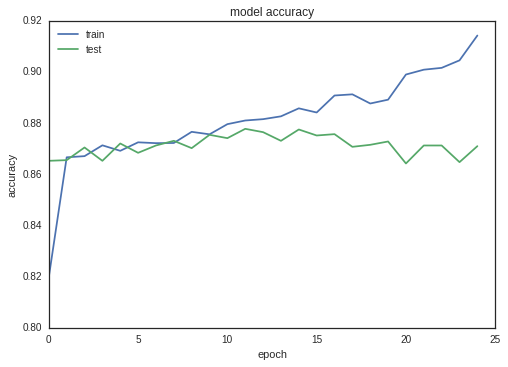

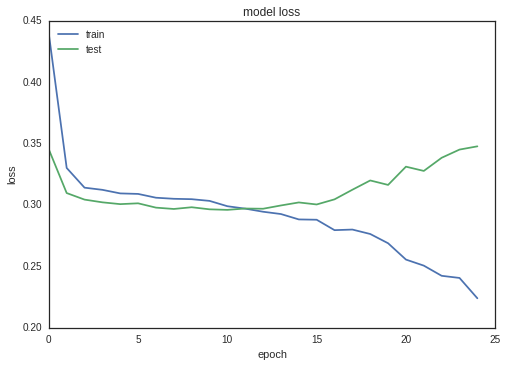

In [24]:
# list all data in history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The above model accuracy and loss charts explains that more tuning is required as the accuracy is not reducing as we increase the epochs / reduce the learning rate. 

# Model Comparisons

Out of all the strategies performed, we see that the strategy that used the pre-trained network with SVM replacing the last layer performed better. 

Some possible reasons could be
1. The pre-trained network had many more layers and could have been already optimized
2. In SVM, the library provides a way to automatically balance an imbalanced dataset by providing the parameter class_weights = "balanced".